In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
bands_numbers = [None, 3, 7, 15]
bands_numbers_labels = ["Full kernel", "3-band kernel", "7-band kernel", "15-band kernel"]

autosimilarity_types = ["Cosine", "Covariance", "RBF"]
penalty_function = "modulo8"
feature = "log_mel_grill"

hop_length = 32
hop_length_seconds = hop_length/44100
subdivision = 96

lambda_range = np.arange(0.1, 2.1, 0.1)

file_test_dataset = open(f"{os.getcwd()}/test_set_salami_gs.txt")

test_dataset = [] # Indexes of the song in the test dataset
for part in file_test_dataset.readlines():
    line_broken = part.split("\n")
    test_dataset.append(int(line_broken[0]))

In [3]:
def learn_and_test_salami(lambda_range, autosimilarity_type = "cosine", bands_number = 15, penalty_func = "modulo8"):
    """
    Learning the lambda parameter on the train subset of the SALAMI dataset, and computes the results on the SALAMI test-dataset.
    """
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    
    results_songs_lambdas = -math.inf * np.ones((len_salami, len(lambda_range), 2, 3))
    
    all_tracks = salami.load_tracks()    
    song_idx = 0
        
    for key, track in all_tracks.items():
        if int(key) not in test_dataset: # File in the train dataset
            try:
                bars = np.load(f"../data/SALAMI/bars/{key}.npy", allow_pickle = True)
                barwise_TF_matrix = scr.load_barwiseTF_salami("../data/SALAMI/barwise_tf", key, feature, subdivision)

                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass

                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    for idx_lambda, lambda_penalty in enumerate(lambda_range):
                        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                        segments_in_time = dm.segments_from_bar_to_time(segments, bars)

                        prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
                        prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
                        this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                        if len(ref_tab) > 1:
                            nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
                            nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
                            if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                                this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                        results_songs_lambdas[song_idx, idx_lambda] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in learning at song {key}, {track}.")
                
            except FileNotFoundError:
                print(f"Song {key} is missing in the data.")

    # Finding the lambda leading to the best trade-off between F_0.5 and F_3.
    avg_songs = [np.mean(results_songs_lambdas[:song_idx, i, 0, 2]) + np.mean(results_songs_lambdas[:song_idx, i, 1, 2]) for i in range(len(lambda_range))]
    best_lambda_idx = np.argmax(avg_songs)
    print(f"Best lambda: {lambda_range[best_lambda_idx]}")

    return fixed_conditions_results_salami(lambda_range[best_lambda_idx], autosimilarity_type = autosimilarity_type, bands_number = bands_number, penalty_func = penalty_func)    

def fixed_conditions_results_salami(lambda_penalty, autosimilarity_type = "cosine", bands_number = 15, penalty_func = "modulo8"):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    results = -math.inf * np.ones((len_salami, 2, 3))
    
    all_tracks = salami.load_tracks()
    song_idx = 0
    
    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = np.load(f"../data/SALAMI/bars/{key}.npy", allow_pickle = True)
                barwise_TF_matrix = scr.load_barwiseTF_salami("../data/SALAMI/barwise_tf", key, feature, subdivision)
  
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                    
                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                    segments_in_time = dm.segments_from_bar_to_time(segments, bars)

                    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
                    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
                    this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                    if len(ref_tab) > 1:
                        nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
                        nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
                        if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                            this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                    results[song_idx] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"Song {key} is missing in the data.")

    print(f"Tested on {song_idx} songs")
    lines = np.array(["Precision 0.5", "Recall 0.5", "F measure 0.5","Precision 3", "Recall 3", "F measure 3"])  
    results_cropped = results[:song_idx]
    return np.array([[round(np.mean(results_cropped[:,0, 0]),5), round(np.mean(results_cropped[:, 0,1]),5), round(np.mean(results_cropped[:, 0,2]),5)], [round(np.mean(results_cropped[:,1, 0]),5), round(np.mean(results_cropped[:, 1,1]),5), round(np.mean(results_cropped[:, 1,2]),5)]])

In [4]:
res_avg_target = math.inf * np.ones((len(bands_numbers), len(autosimilarity_types), 2, 3))

for idx_b, bands_number in enumerate(bands_numbers):
    print(f"Kernel: {bands_number}")
    
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = learn_and_test_salami(lambda_range, autosimilarity_type = autosimil_type, bands_number = bands_number, penalty_func = penalty_function)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_b] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))

Kernel: None
Autosimilarity type: Cosine
Song 710 is missing in the data.
Song 716 is missing in the data.
Song 932 is missing in the data.
Song 1248 is missing in the data.
Song 722 is missing in the data.
Song 720 is missing in the data.
Song 711 is missing in the data.
Song 718 is missing in the data.
Song 1291 is missing in the data.
Song 717 is missing in the data.
Song 63 is missing in the data.
Song 719 is missing in the data.
Song 714 is missing in the data.
Song 709 is missing in the data.
Song 261 is missing in the data.
Song 724 is missing in the data.
Song 878 is missing in the data.
Song 1181 is missing in the data.
Song 712 is missing in the data.
Song 964 is missing in the data.
Song 715 is missing in the data.
Song 923 is missing in the data.
Song 723 is missing in the data.
Best lambda: 0.1
Song 70 is missing in the data.
Song 922 is missing in the data.
Tested on 485 songs
Autosimilarity type: Covariance
Song 710 is missing in the data.
Song 716 is missing in the data

,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.470360,0.333380,0.380680,0.650560,0.460330,0.526010
Autosimilarity: Covariance,0.381240,0.538190,0.433350,0.547490,0.778030,0.623810
Autosimilarity: RBF,0.456920,0.460830,0.445350,0.635840,0.647050,0.622440


Kernel: 3
Autosimilarity type: Cosine
Song 710 is missing in the data.
Song 716 is missing in the data.
Song 932 is missing in the data.
Song 1248 is missing in the data.
Song 722 is missing in the data.
Song 720 is missing in the data.
Song 711 is missing in the data.
Song 718 is missing in the data.
Song 1291 is missing in the data.
Song 717 is missing in the data.
Song 63 is missing in the data.
Song 719 is missing in the data.
Song 714 is missing in the data.
Song 709 is missing in the data.
Song 261 is missing in the data.
Song 724 is missing in the data.
Song 878 is missing in the data.
Song 1181 is missing in the data.
Song 712 is missing in the data.
Song 964 is missing in the data.
Song 715 is missing in the data.
Song 923 is missing in the data.
Song 723 is missing in the data.
Best lambda: 0.1
Song 70 is missing in the data.
Song 922 is missing in the data.
Tested on 485 songs
Autosimilarity type: Covariance
Song 710 is missing in the data.
Song 716 is missing in the data.
S

,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.214910,0.516240,0.292550,0.346880,0.845140,0.474950
Autosimilarity: Covariance,0.270590,0.563030,0.353250,0.403770,0.843210,0.527820
Autosimilarity: RBF,0.242600,0.589750,0.332320,0.362220,0.889800,0.497870


Kernel: 7
Autosimilarity type: Cosine
Song 710 is missing in the data.
Song 716 is missing in the data.
Song 932 is missing in the data.
Song 1248 is missing in the data.
Song 722 is missing in the data.
Song 720 is missing in the data.
Song 711 is missing in the data.
Song 718 is missing in the data.
Song 1291 is missing in the data.
Song 717 is missing in the data.
Song 63 is missing in the data.
Song 719 is missing in the data.
Song 714 is missing in the data.
Song 709 is missing in the data.
Song 261 is missing in the data.
Song 724 is missing in the data.
Song 878 is missing in the data.
Song 1181 is missing in the data.
Song 712 is missing in the data.
Song 964 is missing in the data.
Song 715 is missing in the data.
Song 923 is missing in the data.
Song 723 is missing in the data.
Best lambda: 0.1
Song 70 is missing in the data.
Song 922 is missing in the data.
Tested on 485 songs
Autosimilarity type: Covariance
Song 710 is missing in the data.
Song 716 is missing in the data.
S

,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.295400,0.425630,0.337250,0.460640,0.664610,0.526430
Autosimilarity: Covariance,0.336500,0.572010,0.411410,0.483040,0.827240,0.592220
Autosimilarity: RBF,0.357320,0.555200,0.422080,0.512430,0.804210,0.607510


Kernel: 15
Autosimilarity type: Cosine
Song 710 is missing in the data.
Song 716 is missing in the data.
Song 932 is missing in the data.
Song 1248 is missing in the data.
Song 722 is missing in the data.
Song 720 is missing in the data.
Song 711 is missing in the data.
Song 718 is missing in the data.
Song 1291 is missing in the data.
Song 717 is missing in the data.
Song 63 is missing in the data.
Song 719 is missing in the data.
Song 714 is missing in the data.
Song 709 is missing in the data.
Song 261 is missing in the data.
Song 724 is missing in the data.
Song 878 is missing in the data.
Song 1181 is missing in the data.
Song 712 is missing in the data.
Song 964 is missing in the data.
Song 715 is missing in the data.
Song 923 is missing in the data.
Song 723 is missing in the data.
Best lambda: 0.1
Song 70 is missing in the data.
Song 922 is missing in the data.
Tested on 485 songs
Autosimilarity type: Covariance
Song 710 is missing in the data.
Song 716 is missing in the data.


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.377430,0.364680,0.360190,0.543350,0.522610,0.517370
Autosimilarity: Covariance,0.370990,0.556120,0.432580,0.529570,0.799530,0.619080
Autosimilarity: RBF,0.425830,0.502620,0.449460,0.597030,0.709620,0.632020


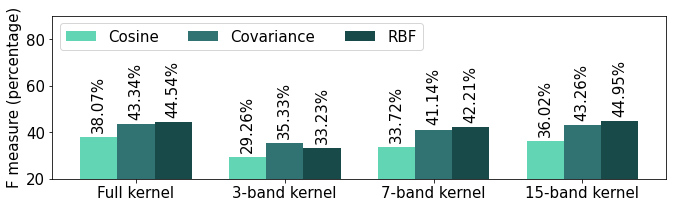

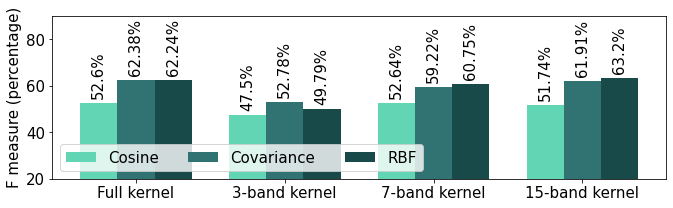

In [5]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 15})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,3))
    ax.set_ylim( 20,90)
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left', ncol = 3)

    else:
        ax.legend(labels=subaxis, loc='upper left', ncol = 3)

    ax.set_ylabel("F measure (percentage)")

    #fig.savefig(f"results_barcomp_salami_{tol}.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()
    
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 0, title = None)#f"F0.5 with the full kernel on SALAMI")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 1, title = None)#f"F3 with the full kernel on SALAMI")